# Word2Vec apply to Spanish songs

The objective is to use Word2Vec to find similar songs

In [264]:
import pandas as pd
import numpy as np
import gensim.models.word2vec as w2v
import multiprocessing
import os
import re
import pprint
import sklearn.manifold
import sklearn.decomposition

import matplotlib.pyplot as plt

## 1. Data Preprocessing

In [201]:
# Dataset of spanish songs
songs = pd.read_csv("../PracticasClase2/hhgroups_merge_28_05.csv", header=0, encoding='utf-8')
songs.head()

,id,artista,cancion,album,letra,anyo,visitas
0,0,Denom,Machete (con Jarfaiter y Gente jodida),Medicina,"Para su nuevo disco ""Medicina"", Denom ha vuelt...",2019,126
1,1,Denom,Vacío (con Ivo Incuerdo),Medicina,"[Denom]\nYo que quería, yo que pedía vida,\nSe...",2019,361
2,2,Denom,El orgullo es fiel (con Juancho Marqués y Elio...,Medicina,"""El orgullo es fiel"" es uno de los cortes incl...",2019,262
3,3,Denom,Mueve mueve (con Fernandocosta),Medicina,"[Estribillo: Denom] (x2)\nMueve, mueve, mueve,...",2019,578
4,4,Jaro Desperdizio,Insomnia,"Sin álbum, es un vídeo suelto","[Estribillo]\nY en esta noche, ¿Quién me arrop...",2019,219


### 1.1 Eliminate Spanish Accents

In [214]:
import unidecode
songs.columns
for i in ['artista','cancion','album','letra']:
    songs[i] = [unidecode.unidecode(j) for j in songs[i]]

In [215]:
songs.head()

,id,artista,cancion,album,letra,anyo,visitas
0,0,Denom,Machete (con Jarfaiter y Gente jodida),Medicina,"Para su nuevo disco ""Medicina"", Denom ha vuelt...",2019,126
1,1,Denom,Vacio (con Ivo Incuerdo),Medicina,"[Denom]\nYo que queria, yo que pedia vida,\nSe...",2019,361
2,2,Denom,El orgullo es fiel (con Juancho Marques y Elio...,Medicina,"""El orgullo es fiel"" es uno de los cortes incl...",2019,262
3,3,Denom,Mueve mueve (con Fernandocosta),Medicina,"[Estribillo: Denom] (x2)\nMueve, mueve, mueve,...",2019,578
4,4,Jaro Desperdizio,Insomnia,"Sin album, es un video suelto","[Estribillo]\nY en esta noche, ?Quien me arrop...",2019,219


### 1.2 Building the vocabulary

To train the model of Word2Vec, we need to build the vocabulary. We are going to do it, iterating in every song and adding it to a list that we are going to feed in to the model.

In [270]:
text_corpus = []

# Add every song to the corpus
for song in songs['letra']:
    words = song.lower().split()
    text_corpus.append(words)

# WordVector Dimensionality
num_features = 200#50
# Minimum word count threshold.
min_word_count = 1

# Proceses to launch in parallel 
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7


downsampling = 1e-1

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

songs2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

songs2vec.build_vocab(text_corpus)
print (len(text_corpus))

9325


## 2. Training the model

In [271]:
import time
start_time = time.time()

# Training the model
songs2vec.train(text_corpus, total_examples=songs2vec.corpus_count, epochs=2)

if not os.path.exists("trained"):
    os.makedirs("trained")

songs2vec.save(os.path.join("trained", "songs2vectors.w2v"))

print("--- %s seconds ---" % (time.time() - start_time))

--- 24.103240966796875 seconds ---


In [272]:
songs2vec = w2v.Word2Vec.load(os.path.join("trained", "songs2vectors.w2v"))

## 3. Exploring the Model

### 3.1 Similar Words

In [273]:
songs2vec.wv.most_similar("amor")

[('amor,', 0.9068390130996704),
 ('dolor,', 0.8770433664321899),
 ('rencor,', 0.8750802278518677),
 ('odio,', 0.8717237114906311),
 ('rencor', 0.8633573055267334),
 ('dolor', 0.8621209263801575),
 ('odio', 0.8604491949081421),
 ('exito', 0.8547095060348511),
 ('sufrimiento', 0.8539490699768066),
 ('sentimiento,', 0.8531209230422974)]

In [274]:
songs2vec.wv.most_similar("fiesta")

[('fiesta,', 0.9065316915512085),
 ('mierda.', 0.8907082080841064),
 ('calle.', 0.8898621201515198),
 ('fila,', 0.8850280046463013),
 ('sala', 0.8832845687866211),
 ('cena', 0.8797311782836914),
 ('cena,', 0.8786762356758118),
 ('tele,', 0.8783419132232666),
 ('playa', 0.8779633045196533),
 ('radio', 0.877659797668457)]

In [275]:
songs2vec.wv.most_similar("perreo")

[('bemeta', 0.9917676448822021),
 ('ralentiza', 0.990942120552063),
 ('oraculo', 0.9893496036529541),
 ('cesped,', 0.9892410039901733),
 ('opresion...', 0.9891447424888611),
 ('mostrado,', 0.9889326691627502),
 ('tigre.', 0.988507866859436),
 ('marcaran', 0.9882950782775879),
 ('warrimor', 0.9882235527038574),
 ('chilaba', 0.988213062286377)]

### 3.2 Distance Between Words

In [276]:
songs2vec.wv.distance("amor", "sexo")

0.19738274812698364

In [277]:
songs2vec.wv.distance("amor", "querer")

0.27420079708099365

In [278]:
songs2vec.wv.distance("fiesta", "alcohol")

0.24832946062088013

In [279]:
songs2vec.wv.distance("fiesta", "diversion")

0.16914087533950806

In [280]:
songs2vec.wv.distance("fiesta", "ruido")

0.22709888219833374

### 3.3 Similarity between words 

In [281]:
songs2vec.wv.n_similarity(['alcohol', 'botella'], ['sol', 'playa'])

0.8962239

In [282]:
songs2vec.wv.n_similarity(['amor', 'querer'], ['sol', 'playa'])

0.71060336

### 3.4 Words out of context

In [283]:
songs2vec.wv.doesnt_match("felicidad amor alegría sexo".split())

C:\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'felicidad'

In [284]:
songs2vec.most_similar(positive=['playa', 'alcohol'], negative=['sol'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('plata,', 0.8578765392303467),
 ('plata', 0.8497165441513062),
 ('alcohol,', 0.8436019420623779),
 ('vendiendo', 0.835134744644165),
 ('calidad', 0.8344078063964844),
 ('ases', 0.833860456943512),
 ("'e", 0.8335532546043396),
 ('coca,', 0.8334610462188721),
 ('gastando', 0.8328786492347717),
 ('droga,', 0.8283078670501709)]

### 3.5 Semantic distance between words 

In [285]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = songs2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{0} es a {1}, lo que {2} es a {3}".format(start1, end1, start2, end2))

In [286]:
nearest_similarity_cosmul("paris", "francia", "alabama")

paris es a francia, lo que tierra! es a alabama


In [287]:
nearest_similarity_cosmul("sol", "playa", "amor")

sol es a playa, lo que dolor es a amor


In [288]:
nearest_similarity_cosmul("botella", "alcohol", "amor")

botella es a alcohol, lo que despedida es a amor


### 3.6 Calculate the normalized vector for each song

In [289]:
print(songs2vec['amor'])
def songVector(row):
    vector_sum = 0
    words = row.lower().split()
    for word in words:
        vector_sum = vector_sum + songs2vec[word]
    vector_sum = vector_sum.reshape(1,-1)
    normalised_vector_sum = sklearn.preprocessing.normalize(vector_sum)
    return normalised_vector_sum


import time
start_time = time.time()

songs['song_vector'] = songs['letra'].apply(songVector)



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

[-3.66683155e-02  5.11220507e-02 -2.21226327e-02 -5.27839586e-02
  1.83619663e-01 -7.94635266e-02 -1.35092378e-01  1.61982983e-01
 -5.90407968e-01 -4.24234003e-01  4.10749823e-01 -2.24002108e-01
 -6.53418005e-02 -2.48717830e-01  1.01210132e-01  2.47307658e-01
  1.31177559e-01  1.38018355e-01  3.22023004e-01  5.36341080e-03
  2.68404514e-01 -7.08700418e-01  8.86704028e-02  3.84655982e-01
  4.06955361e-01  1.11353152e-01 -1.40307128e-01  1.71405256e-01
 -1.47570953e-01 -4.89559710e-01 -4.26648706e-01  1.91151604e-01
  3.27439696e-01  1.84386019e-02  9.53351930e-02 -2.47618392e-01
 -1.67339176e-01  1.52961299e-01 -2.82020159e-02  1.86543107e-01
 -2.64305949e-01  5.27379736e-02 -1.26790658e-01 -1.24185793e-01
 -8.59967992e-02 -3.64466101e-01  2.35152006e-01  8.90137628e-02
  2.39048272e-01 -2.88880795e-01  2.93377995e-01 -2.22307220e-01
 -5.82149439e-02  3.31206471e-01 -4.28732067e-01  1.79052457e-01
  3.04879695e-01 -3.06703359e-01 -2.94724345e-01 -4.19380009e-01
 -3.36259082e-02  1.45197

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated

### 3.7 T-sne and selecction of random songs 

The songs have 200 dimensions each, so we are going to apply T-sne. Because this operation is computationally expensive, the sample is going to be only of 57000 songs.

In [290]:
song_vectors = []
from sklearn.model_selection import train_test_split

train, test = train_test_split(songs, test_size = 0.9)


for song_vector in train['song_vector']:
    song_vectors.append(song_vector)

train.head(10)

,id,artista,cancion,album,letra,anyo,visitas,song_vector
7796,11,Nach,Entre el placer y el dolor (con Santiuve),A traves de mi,"[Estribillo: Nach, Santiuve] (x2)\nEntre el pl...",2015,12373,"[[0.03875657, 0.034994595, -0.025223903, -0.11..."
5000,20,Toteking,Peligroso,Lebron,"Un cabron ahi solo, escupe honestidad,\nDos he...",2018,2122,"[[0.022327231, 0.034423113, -0.02796538, -0.09..."
2122,32,Currice,Quiza es tarde,Profecia,"Se que te dije adios, rompi tu corazon\npero a...",2009,6438,"[[0.0016695766, 0.022021063, -0.028962059, -0...."
91,36,Denom,Ansiedad y recuerdos (con Prok),Medicina,"[Prok]\nOigo esos muertos, pienso rapido,\nMue...",2019,6454,"[[0.038670402, 0.035468627, -0.032769706, -0.1..."
5120,30,Sticky M.A.,Yanoay,Las pegajosas aventuras de Sticky M.A.,"Parece muy complicado pero bueno,\nAhora tengo...",2018,4765,"[[0.009032577, 0.027367504, -0.039096937, -0.0..."
7956,6,Los chikos del maiz,La estanquera de Saigon (con Habeas Corpus),La estanquera de Saigon,[Nega]\nSoy el rap que escucharia Ho Chi Minh ...,2014,12610,"[[0.023012824, 0.028580792, 0.0038593193, -0.0..."
6215,25,Lagrimas de sangre,Brea y plumas,Viridarquia,[Microbio]\nPor cada cosa que aprendimos a las...,2016,4916,"[[0.027732402, 0.029406706, -0.03351755, -0.10..."
2031,51,Little Pepe,Long time (con Morodo),Ponle mente,Me siento orgulloso de ver\nComo viaja mi liri...,2008,7271,"[[0.029127324, 0.04245076, -0.031343613, -0.08..."
5258,3,Krvzy,Pagame tu el pato,"Sin album, es un tema suelto","La muerte esta noche me pisa los talones,\nLa ...",2017,304,"[[0.018336924, 0.038432922, -0.024269022, -0.1..."
6308,8,Kase.O,Yemen,El circulo,"Me da panico mi propio ego, ciego de mi mismo ...",2016,65723,"[[0.02301132, 0.02989441, -0.022064978, -0.094..."


Becaue we have many dimensions we are going to use PCA and after that T-sne. We can tune the number of interactions, learning rate and other factors to adjust the model.

In [302]:
X = np.array(song_vectors).reshape((932, 200))

start_time = time.time()

# PCA 
pca = sklearn.decomposition.PCA(n_components=3)

#T-sne
tsne = sklearn.manifold.TSNE(n_components=3, n_iter=2000, random_state=50, verbose=2,
                            learning_rate=200, perplexity=100)

X_1 = pca.fit_transform(X)
all_word_vectors_matrix_2d = tsne.fit_transform(X_1)

print("--- %s seconds ---" % (time.time() - start_time))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 932 samples in 0.000s...
[t-SNE] Computed neighbors for 932 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 932 / 932
[t-SNE] Mean sigma: 0.018593
[t-SNE] Computed conditional probabilities in 0.121s
[t-SNE] Iteration 50: error = 55.2048111, gradient norm = 0.0609818 (50 iterations in 1.708s)
[t-SNE] Iteration 100: error = 53.2596092, gradient norm = 0.0447107 (50 iterations in 1.250s)
[t-SNE] Iteration 150: error = 53.2600327, gradient norm = 0.0431384 (50 iterations in 1.055s)
[t-SNE] Iteration 200: error = 53.2628822, gradient norm = 0.0352863 (50 iterations in 1.052s)
[t-SNE] Iteration 250: error = 53.2610512, gradient norm = 0.0425057 (50 iterations in 1.028s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.261051
[t-SNE] Iteration 300: error = 0.4495837, gradient norm = 0.0005158 (50 iterations in 1.273s)
[t-SNE] Iteration 350: error = 0.4028001, gradient norm = 0.0004019 

In [303]:
df=pd.DataFrame(all_word_vectors_matrix_2d,columns=['X','Y','Z'])
df.head(10)

train.head()

df.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

We unite the two dataframes to obtain the coordinates X, Y, Z of the songs.

In [304]:
two_dimensional_songs = pd.concat([train, df], axis=1)

two_dimensional_songs.head()

,id,artista,cancion,album,letra,anyo,visitas,song_vector,X,Y,Z
0,11,Nach,Entre el placer y el dolor (con Santiuve),A traves de mi,"[Estribillo: Nach, Santiuve] (x2)\nEntre el pl...",2015,12373,"[[0.03875657, 0.034994595, -0.025223903, -0.11...",3.453849,1.135433,-4.939539
1,20,Toteking,Peligroso,Lebron,"Un cabron ahi solo, escupe honestidad,\nDos he...",2018,2122,"[[0.022327231, 0.034423113, -0.02796538, -0.09...",-2.571740,2.138177,-0.508295
2,32,Currice,Quiza es tarde,Profecia,"Se que te dije adios, rompi tu corazon\npero a...",2009,6438,"[[0.0016695766, 0.022021063, -0.028962059, -0....",-0.404400,-2.945299,9.741396
3,36,Denom,Ansiedad y recuerdos (con Prok),Medicina,"[Prok]\nOigo esos muertos, pienso rapido,\nMue...",2019,6454,"[[0.038670402, 0.035468627, -0.032769706, -0.1...",0.432995,2.175031,-4.873858
4,30,Sticky M.A.,Yanoay,Las pegajosas aventuras de Sticky M.A.,"Parece muy complicado pero bueno,\nAhora tengo...",2018,4765,"[[0.009032577, 0.027367504, -0.039096937, -0.0...",-2.743789,-2.284752,7.118643


### 3.8 Plot the Results

Using plotly, plot the results so it is easier to explore songs with similar colors and clusters.pintemos los resultados para que sea más facil explorar canciones similares basadas en color y clusters.

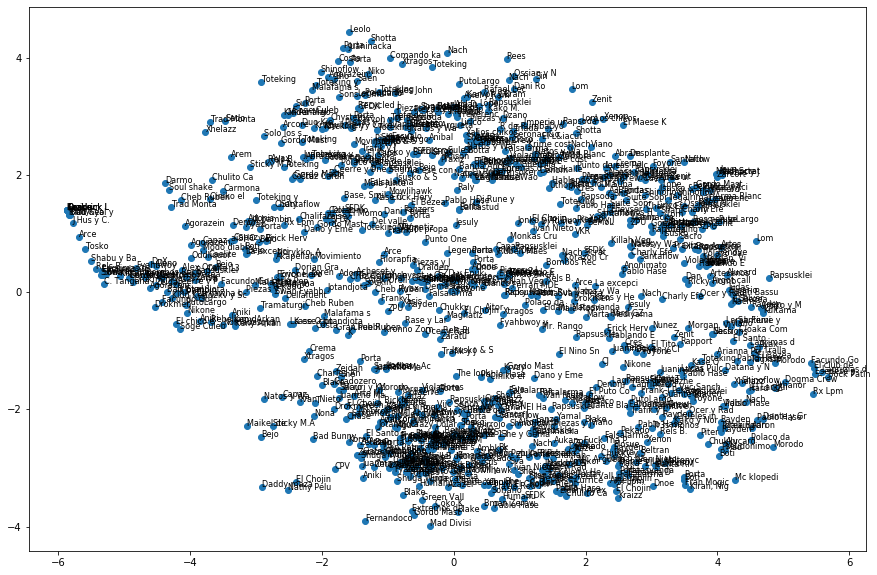

In [364]:
plt.rcParams['figure.figsize'] = [15, 10]
x=all_word_vectors_matrix_2d[:,0]
y=all_word_vectors_matrix_2d[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(train['artista'], x, y):
    ax.annotate(item[0:10], (x1, y1), size=8)

plt.show()